In [1]:
from os import environ as ENV

import pandas as pd
import bct
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [3]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

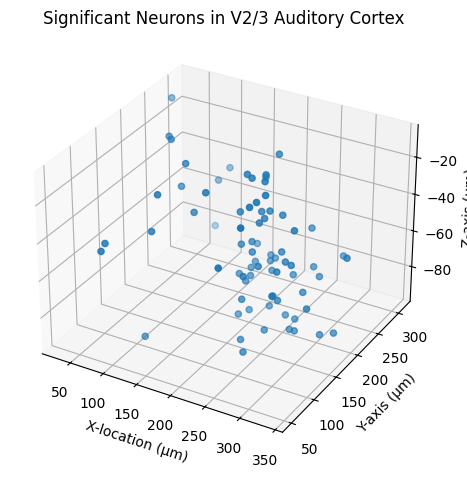

In [4]:
# Correlation mapping of significant neurons in V2/3 Auditory Cortex
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(coords['x'], coords['y'], coords['z'])
ax.set_xlabel('X-location (µm)')
ax.set_ylabel('Y-axis (µm)')
ax.set_zlabel('Z-axis (µm)')
ax.set_title('Significant Neurons in V2/3 Auditory Cortex')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/sig_neurons_cortex.png', dpi=300)
plt.show()

In [5]:
# load data
quantum_fidelity_amp_qft_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed_qft.csv', index_col=0)
quantum_fidelity_amp_qft_df.columns = [int(i) for i in quantum_fidelity_amp_qft_df.columns]
quantum_fidelity_amp_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed.csv', index_col=0)
quantum_fidelity_amp_df.columns = [int(i) for i in quantum_fidelity_amp_df.columns]
quantum_fidelity_ang_df = pd.read_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed.csv', index_col=0)
quantum_fidelity_ang_df.columns = [int(i) for i in quantum_fidelity_ang_df.columns]
corrs_df = pd.read_csv(ENV['PWD'] + '/data/classical-correlations.csv', index_col=0)
corrs_df.columns = [int(i) for i in corrs_df.columns]
euclidean_dist_df = pd.read_csv(ENV['PWD'] + '/data/euclidean_distance.csv', index_col=0)
euclidean_dist_df.columns = [int(float(i)) for i in euclidean_dist_df.columns]


In [6]:
def rescale(x):
    flat = x.to_numpy().flatten()
    return (flat - np.min(flat)) / (np.max(flat) - np.min(flat))

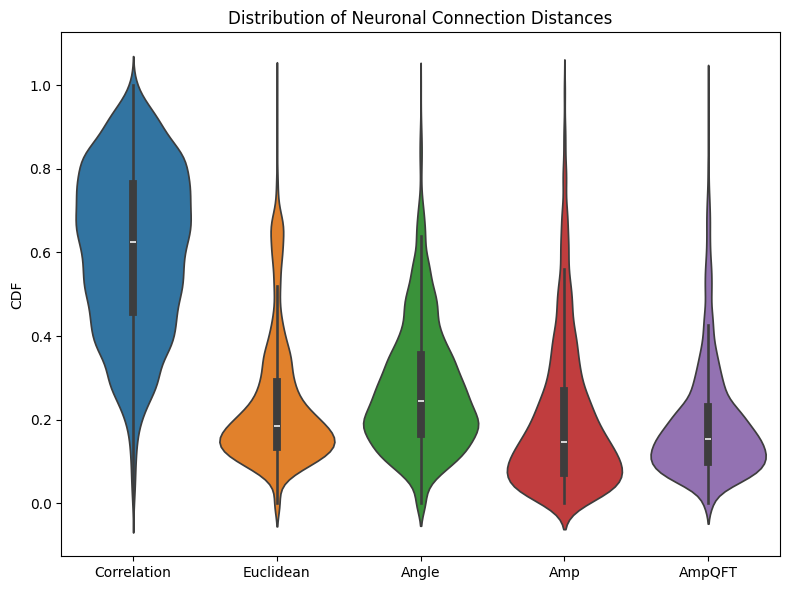

In [7]:
plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 6))

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    'Euclidean': rescale(euclidean_dist_df),
    'Angle': rescale(1-quantum_fidelity_ang_df),
    'Amp': rescale(1-quantum_fidelity_amp_df),
    'AmpQFT': rescale(1-quantum_fidelity_amp_qft_df),
}
sns.violinplot(data_dict)

# plt.xlabel("Metric name")
plt.ylabel("CDF")
plt.title("Distribution of Neuronal Connection Distances")
plt.tight_layout()
plt.show()

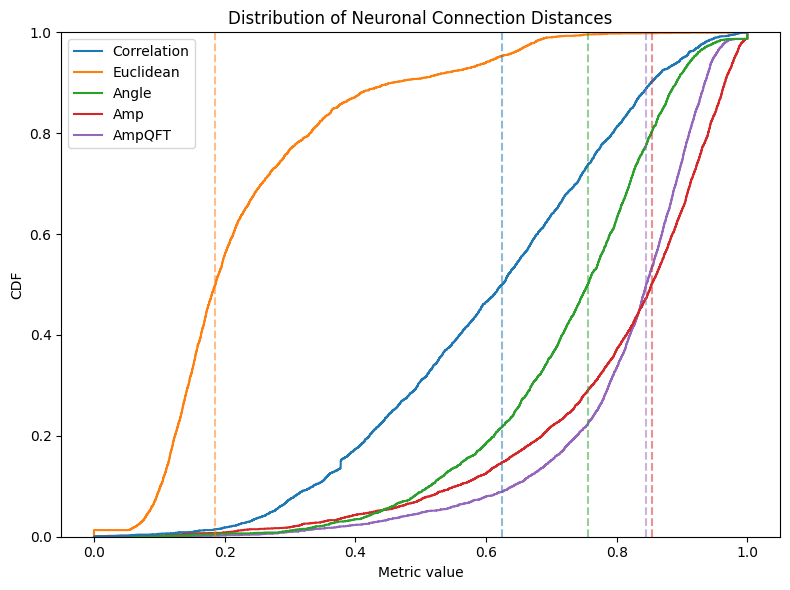

In [8]:
plt.close()
# Plot Distribution of Neuronal Connection Distances
plt.figure(figsize=(8, 6))
default_palette = sns.color_palette()
first_five_colors = default_palette[:5]

data_dict = {
    'Correlation': rescale(corrs_df), # add 1 to make corrs non-negative
    'Euclidean': rescale(euclidean_dist_df),
    'Angle': rescale(quantum_fidelity_ang_df),
    'Amp': rescale(quantum_fidelity_amp_df),
    'AmpQFT': rescale(quantum_fidelity_amp_qft_df),
}
sns.ecdfplot(data_dict)
i=0
for metric, data in data_dict.items():
    median_x = np.median(data)
    plt.axvline(median_x, linestyle='--', alpha=0.5, c=default_palette[i])
    i+=1

plt.xlabel("Metric value")
plt.ylabel("CDF")
plt.title("Distribution of Neuronal Connection Distances")
plt.tight_layout()
plt.show()

In [9]:
import itertools

In [10]:
def make_graph(dist_matrix):
    # Minimum Spanning Tree (MST)
    G = nx.Graph()
    for i in dist_matrix.index:
        G.add_node(i, pos=coords.loc[i])
    for (i, j) in itertools.combinations(dist_matrix.index, 2):
        G.add_edge(i, j, weight=dist_matrix.loc[i][j])
    return G

In [11]:
# prepare matrices

In [12]:
import networkx as nx
# draw graphs


In [13]:
# MST of fidelity is maximize 1-fidelity
matrices = [
    corrs_df,
    euclidean_dist_df,
    1-quantum_fidelity_ang_df,
    1-quantum_fidelity_amp_df,
    1-quantum_fidelity_amp_qft_df,
]

In [14]:
graphs = [make_graph(i) for i in matrices]
graph_labels = [ "Correlation", "Euclidean", "Angle", "Amp", "AmpQFT",]

In [15]:
def remove_edges_under_percentile(G, percentile):
    new_G = G.copy()
    # Get edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if G[u][v]['weight'] is not None]

    # Calculate percentile
    threshold = np.percentile(edge_weights, percentile)

    # Identify and remove edges
    edges_to_remove = [(u, v) for u, v in new_G.edges() if new_G[u][v]['weight'] < threshold]
    new_G.remove_edges_from(edges_to_remove)

    return new_G

In [16]:
# threshold graphs not with bctpy but with networkx
# import bct
msts = [nx.minimum_spanning_tree(g) for g in graphs]
threshold_95 = [remove_edges_under_percentile(g, 95) for g in graphs]
threshold_90 = [remove_edges_under_percentile(g, 90) for g in graphs]


In [17]:
def average_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [18]:
# need to threshold graphs such that the average degree is >2 but less than the square of the number of neurons
# region of intermediate sparsity
# https://www.nature.com/articles/s41467-019-08746-5
76**0.5

8.717797887081348

In [19]:
[average_degree(g) for g in msts] # < 2


[1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157,
 1.9736842105263157]

In [20]:
[average_degree(g) for g in threshold_95] # < 2

[3.763157894736842,
 3.763157894736842,
 3.763157894736842,
 3.763157894736842,
 3.763157894736842]

In [21]:
[average_degree(g) for g in threshold_90] # < 2


[7.5, 7.5, 7.5, 7.5, 7.5]

In [22]:
# sparsity conditions satisfied

# Plotting networks

## 2D

In [23]:
def plot_graph_circular(G, title, ax):
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=10, node_color='royalblue')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, alpha=0.6)

    ax.set_title(title, fontsize=20)
    ax.set_frame_on(False)
    ax.set_axis_off()


def plot_2d_wrapper(graphs, suffix):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    for i in range(len(graphs)):
        plot_graph_circular(graphs[i], graph_labels[i], axes[i])

    # Hide the last unused subplot
    axes[-1].axis('off')

    plt.suptitle(f'2D functional networks ({suffix})', fontsize=20)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-2d-{suffix}.png', dpi=300)


plt.close()
for graph_list, suffix in zip([msts, threshold_95, threshold_90, threshold_85], ['MST', 'top 5%', 'top 10%', 'top 15%']):
    plot_2d_wrapper(graph_list, suffix)
plt.show()


In [24]:
def plot_2d_wrapper_grid(graph_lists, graph_labels, suffixes):
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    j = 0
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            plot_graph_circular(graphs[i], graph_labels[i], axes[j])
            if j >= 5:
                axes[j].set_title('') # hide title of columns
            if j % 5 == 0:
                axes[j].set_axis_on()
                axes[j].set_frame_on(False)
                axes[j].set_ylabel(sfx, fontsize=20, rotation=0, ha='right')
            j+=1

    # Hide the last unused subplot
    # axes[-1].axis('off')

    # plt.suptitle(f'2D functional networks ({suffix})', fontsize=20)
    plt.suptitle('2D functional networks', fontsize=28)
    # fig.subplots_adjust(top=0.93)  # move suptitle down
    
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-2d-grid.png', dpi=300)


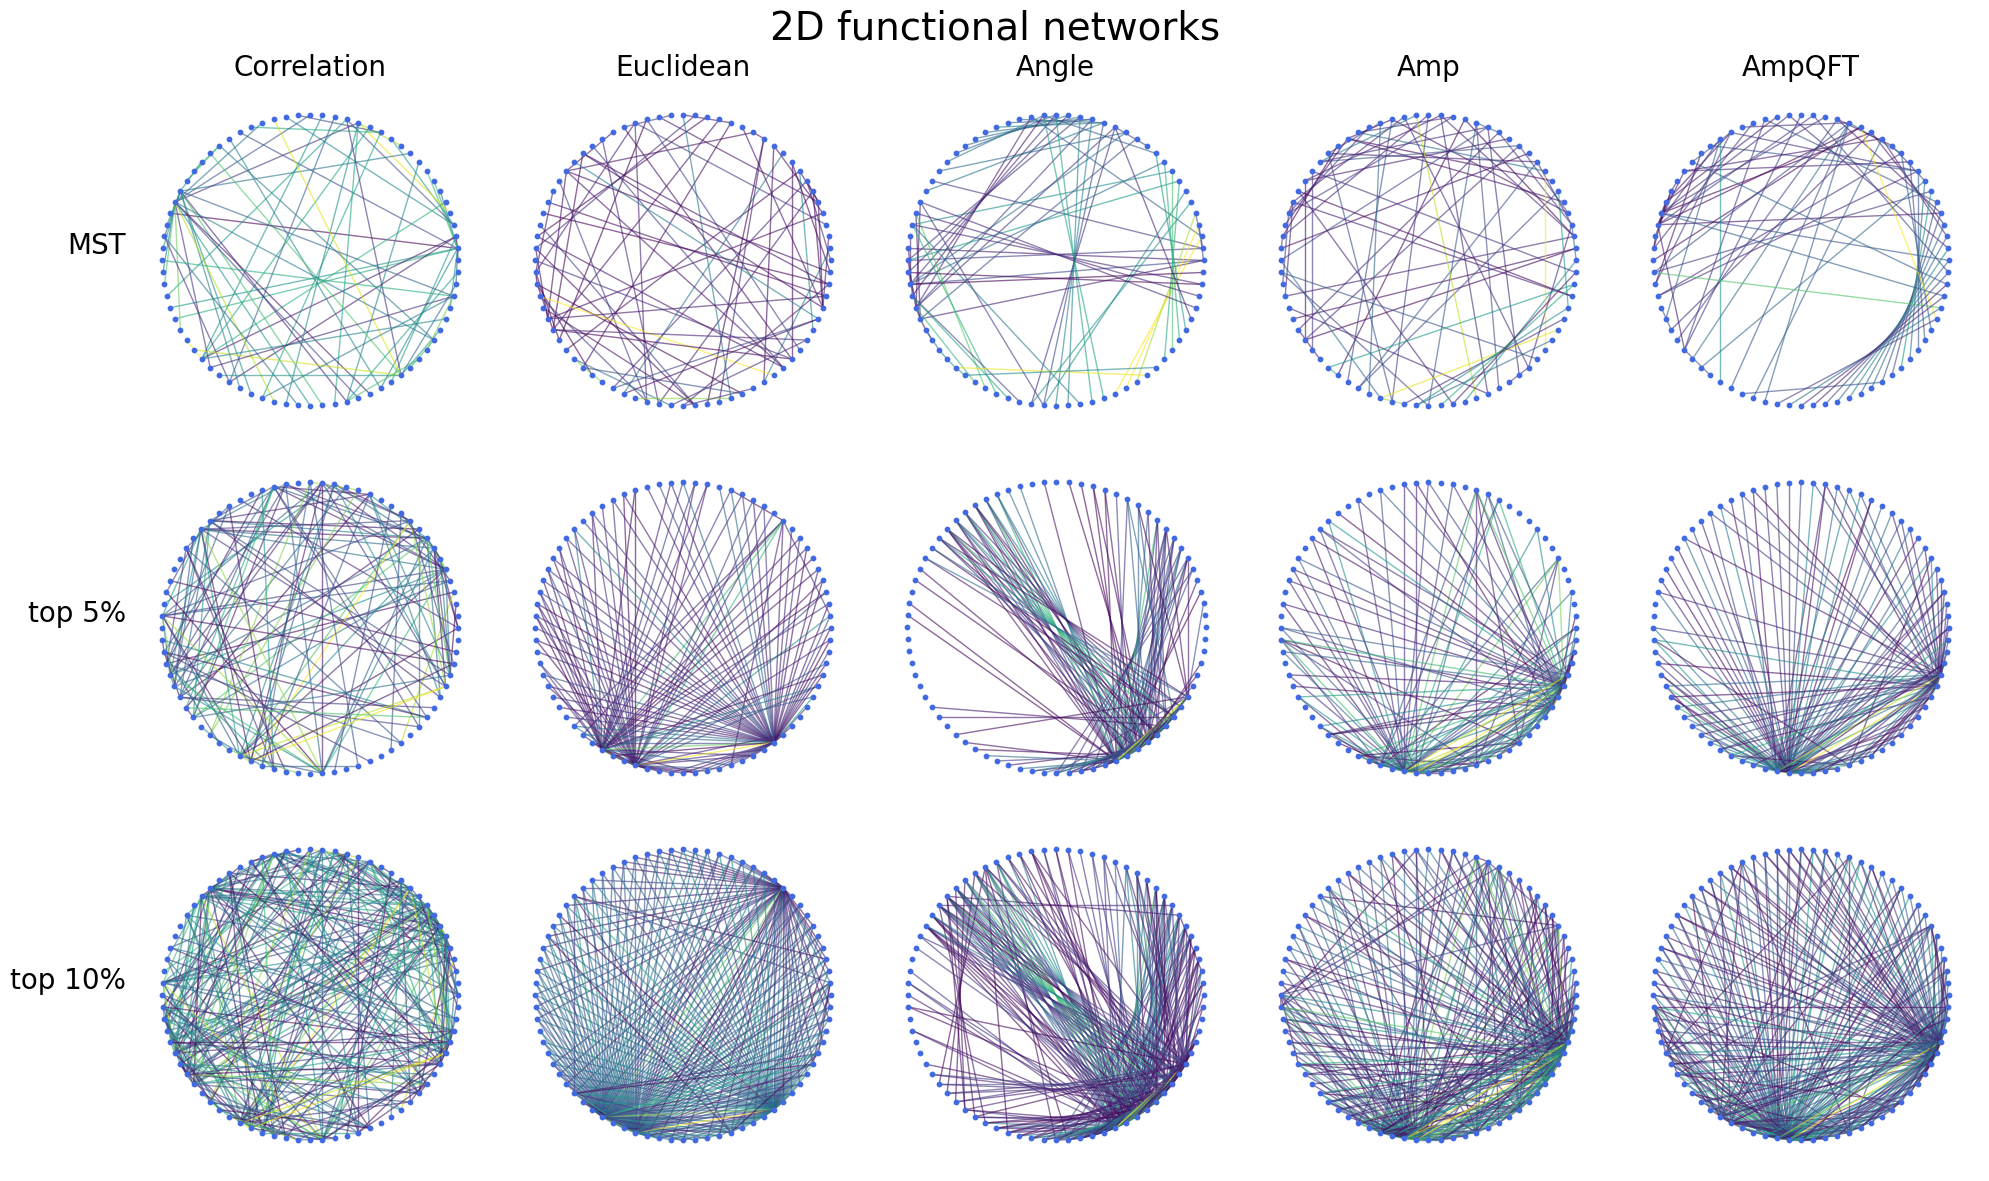

In [25]:
plot_2d_wrapper_grid([msts, threshold_95, threshold_90],
                     graph_labels,
                     ['MST', 'top 5%', 'top 10%'])

## 3D

In [26]:
# Plot the MSTs

def plot_graph_3d(G, title, ax, node_color='royalblue'):
    pos = nx.get_node_attributes(G, 'pos')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=weights.min(), vmax=weights.max())

    for u, v in G.edges():
        x = [pos[u]['x'], pos[v]['x']]
        y = [pos[u]['y'], pos[v]['y']]
        z = [pos[u]['z'], pos[v]['z']]
        weight = G[u][v]['weight']
        edge_color = cmap(norm(weight))
        ax.plot(x, y, z, color=edge_color, alpha=0.6)

    xs, ys, zs = zip(*pos.values())
    # print(xs, ys, zs)
    ax.scatter(xs, ys, zs, s=10, color=node_color)
    ax.set_title(title, fontsize=20)
    # ax.set_axis_off()
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('z')

def plot_3d_wrapper(graphs, suffix):

    plt.close()

    fig = plt.figure(figsize=(16, 10))
    for i in range(5):
        plot_graph_3d(graphs[i], graph_labels[i], fig.add_subplot(2, 3, i+1, projection='3d'))

    plt.suptitle(f'3D functional networks ({suffix})', fontsize=20)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-3d-{suffix}.png', dpi=300)

    plt.show()

for graph_list, suffix in zip([msts, threshold_95, threshold_90, threshold_85], ['MST', 'top 5%', 'top 10%', 'top 15%']):
    plot_3d_wrapper(graph_list, suffix)

In [27]:
def plot_3d_wrapper_grid(graph_lists, graph_labels, suffixes):

    plt.close()

    fig, axes = plt.subplots(3, 5, figsize=(22, 12), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    j = 0
    for graphs, sfx in zip(graph_lists, suffixes):
        for i in range(len(graphs)):
            # print(j)
            plot_graph_3d(graphs[i], graph_labels[i], axes[j]) # , fig.add_subplot(2, 3, i+1, projection='3d'))
            if j >= 5:
                axes[j].set_title('') # hide title of columns

            j+=1

    plt.suptitle(f'3D functional networks', fontsize=28)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/network-3d-grid.png', dpi=300)

    plt.show()

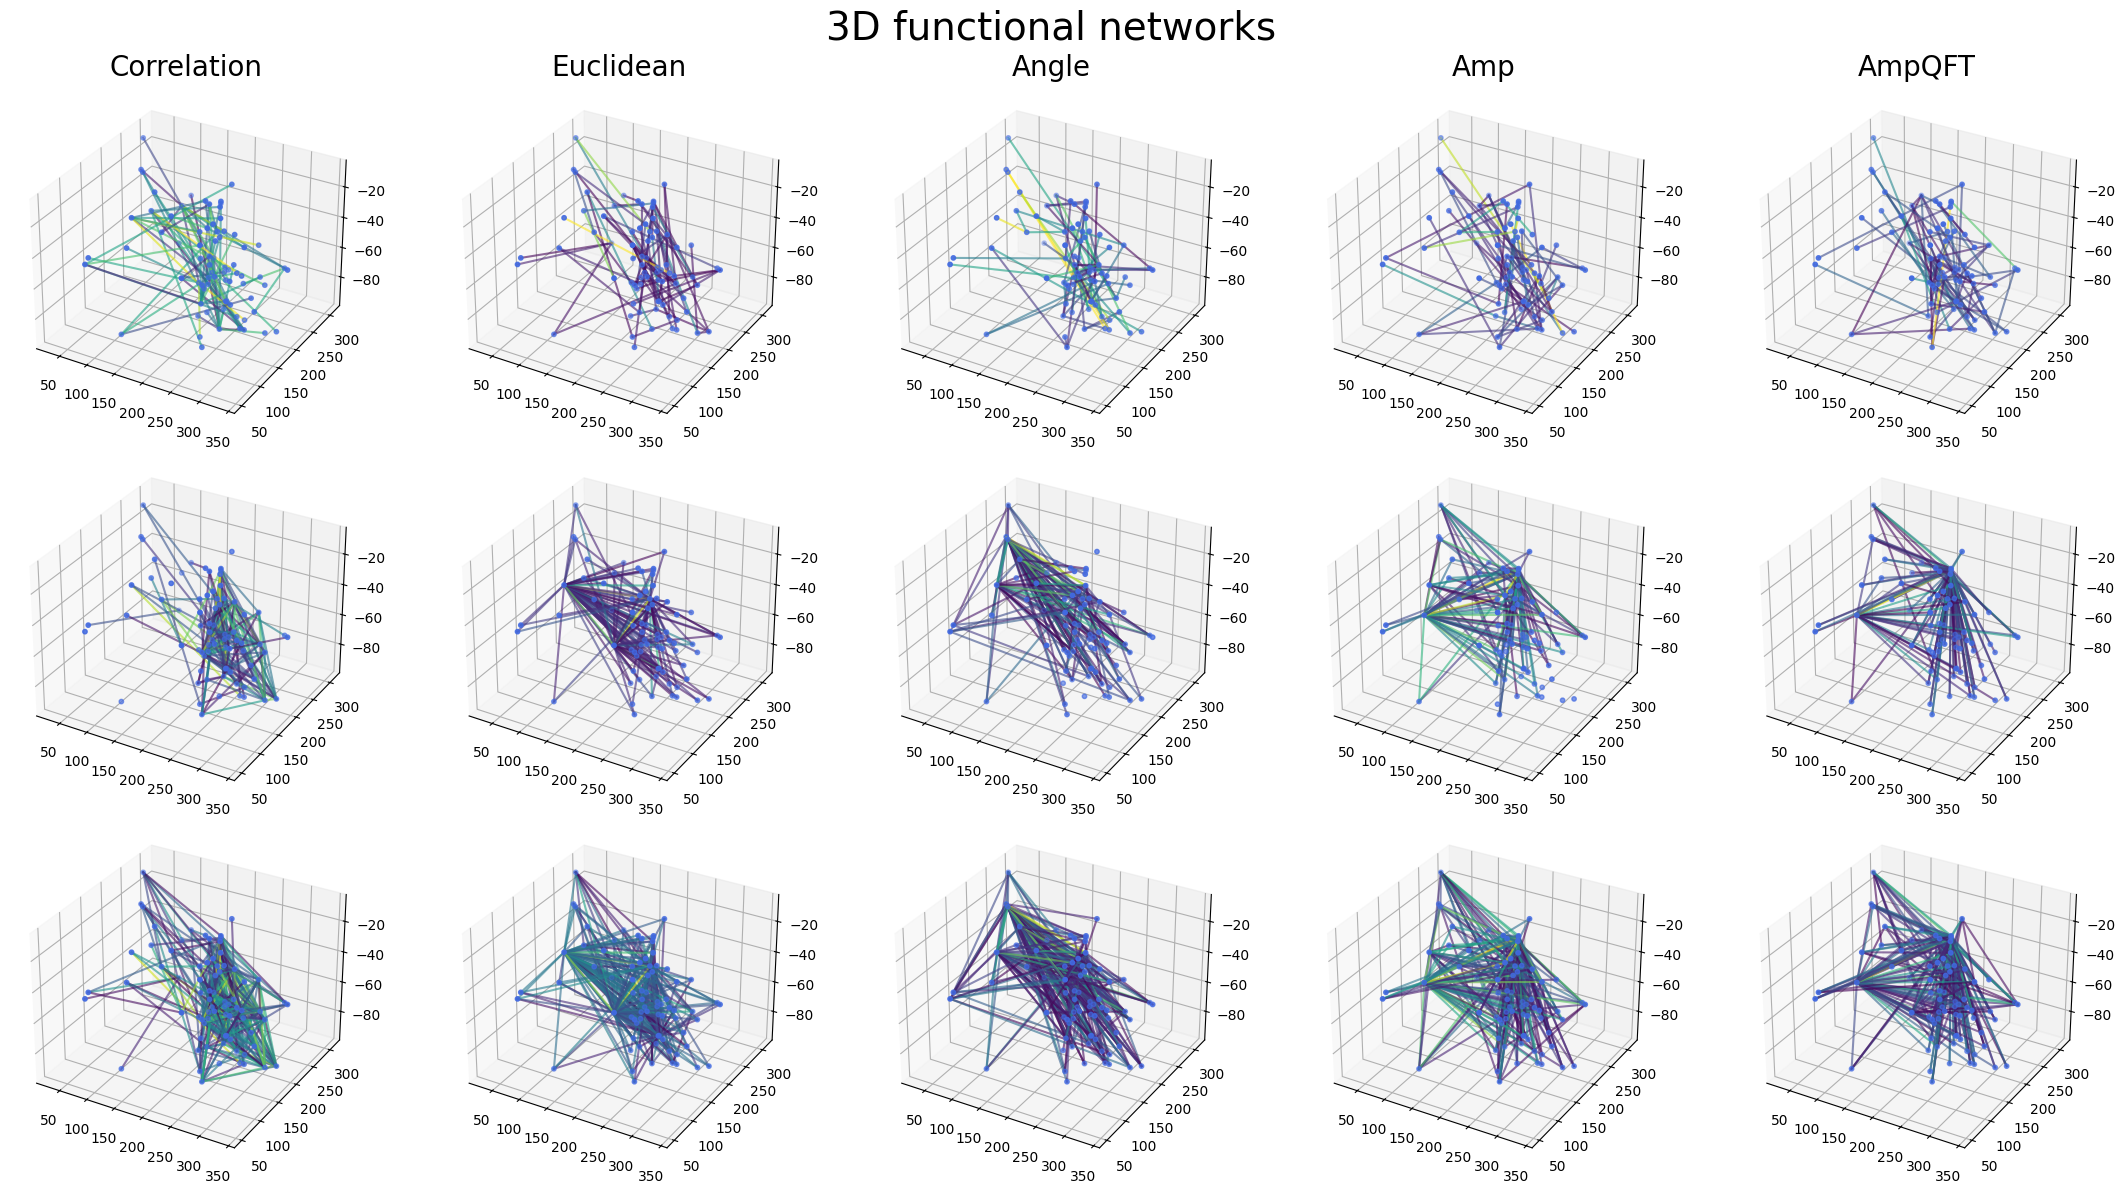

In [28]:
plot_3d_wrapper_grid([msts, threshold_95, threshold_90],
                     graph_labels,
                     ['MST', 'top 5%', 'top 10%'])

# Rent's analysis

In [29]:
import numpy as np
import statsmodels.api as sm
from scipy import stats

def rentian_scaling_linreg(adj_matrix, coords, n=300, threshold=0.9, confidence=0.95):
    """
    Compute Rentian scaling slope and its confidence interval.

    Parameters:
    adj_matrix (numpy array): Adjacency matrix of the network.
    coords (numpy array): Coordinates of the nodes in the network.
    n (int, optional): Number of iterations for Rentian scaling. Defaults to 300.
    threshold (float, optional): Threshold for binarizing the adjacency matrix. Defaults to 0.9.
    confidence (float, optional): Confidence level for the interval. Defaults to 0.95.

    Returns:
    tuple: Computed slope and its confidence interval.
    """

    # Binarize the adjacency matrix
    # sc_matrix = adj_matrix
    # adj_matrix = (sc_matrix >= threshold).astype(int)
    # np.fill_diagonal(adj_matrix, 0)

    # Run Rentian scaling
    N, E = rentian_scaling(adj_matrix, coords, n=n)
    mask = (N > 0) & (E > 0)
    log_N = np.log10(N[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)
    log_E = np.log10(E[mask]).reshape(-1, 1) #[mask]).reshape(-1, 1)

    # Add a constant (intercept) to the independent value
    X = sm.add_constant(log_N)

    # Linear regression
    model = sm.OLS(log_E, X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    r2 = model.rsquared

    # Confidence interval for the slope
    stderr = model.bse[1]
    interval = stats.t.ppf((1 + confidence) / 2, len(log_E) - 2) * stderr
    ci = (slope - interval, slope + interval)

    return slope, (slope, slope - interval, slope + interval), log_N, log_E, intercept, r2, ci


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=None, confidence=0.95):
    if ax is None:
        ax = plt.gca()

    # Plot the data points
    ax.scatter(log_N, log_E, s=20, alpha=0.9, color='gray') # , label='Samples')

    # Plot the fitted line
    log_N_fit = np.linspace(log_N.min(), log_N.max(), 100).reshape(-1, 1)
    log_E_fit = slope * log_N_fit + intercept
    ax.plot(log_N_fit, log_E_fit, color='crimson', linewidth=2,
             label=f'Fit: slope = {slope:.2f}, $R^2$ = {r2:.2f}')

    ax.set_xlabel(r"log$_{10}$(Number of nodes in cube)")
    ax.set_ylabel(r"log$_{10}$(Number of crossing edges)")
    # ax.set_title("Linear Regression")
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right')


In [31]:
def plot_rentian_scaling_wrapper_grid(inputs, graph_labels, suffixes):
    plt.close()
    intervals = []
    fig, axes = plt.subplots(2, 5, figsize=(24, 10))
    axes = axes.flatten()
    j = 0
    for input_, sfx in zip(inputs, suffixes):
        for i in range(len(input_)):
            adj_matrix = input_[i]
            slope, interval, log_N, log_E, intercept, r2, ci = rentian_scaling_linreg(adj_matrix, coords.to_numpy())
            plot_linear_regression(log_N, log_E, slope, intercept, r2, ax=axes[j])
            # axes[j].set_title(j)
            if j % 5 != 0:
                axes[j].set_ylabel('')
            if j < 5:
                axes[j].set_xlabel('')
                axes[j].set_title(graph_labels[i], fontsize=20)
            j += 1
            intervals.append(interval)

    plt.suptitle(f'Rentian Scaling', fontsize=28)
    plt.tight_layout()
    plt.savefig(ENV['PWD'] + f'/figures/rentian-scaling-grid.png', dpi=300)

    plt.show()
    return intervals

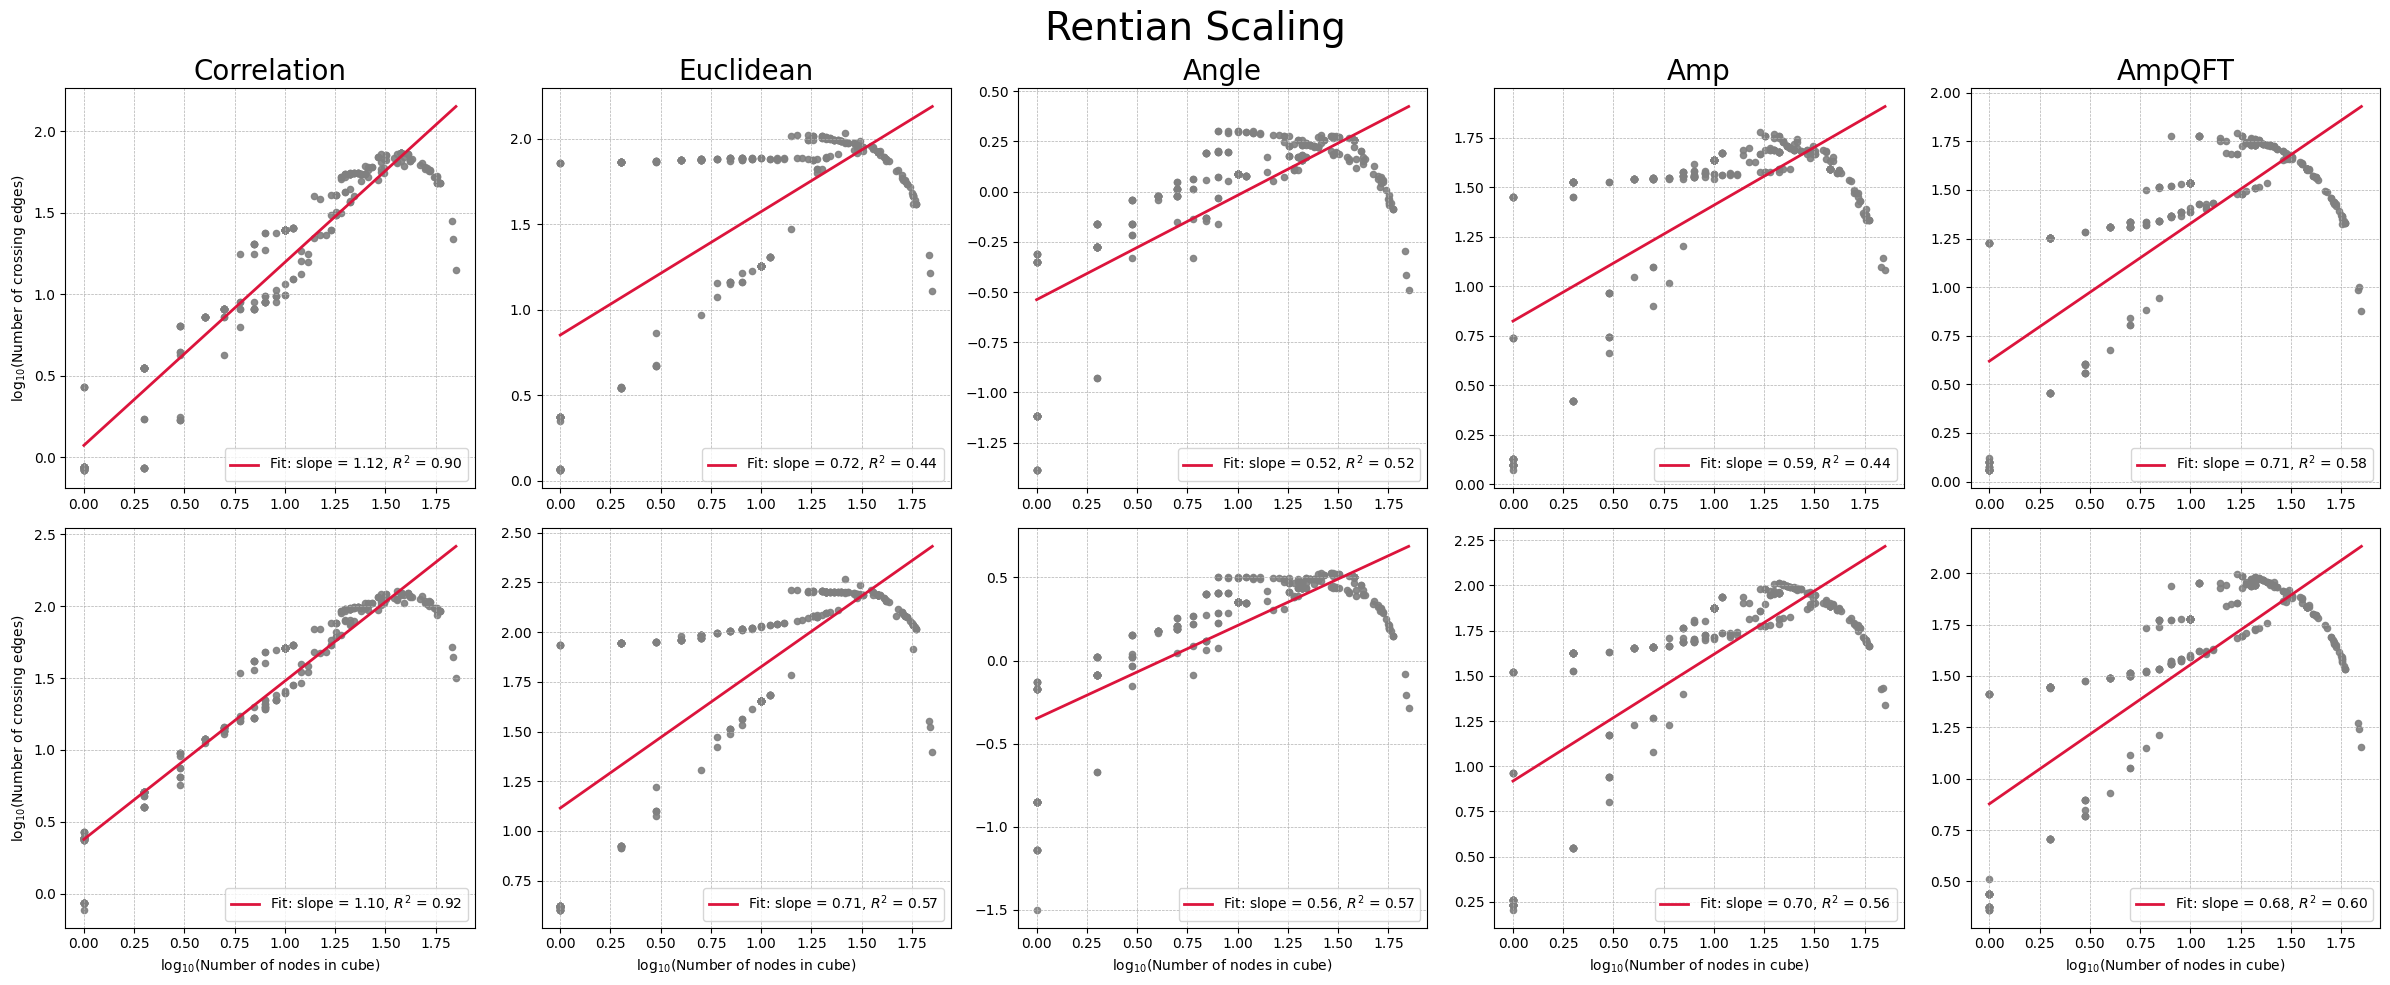

In [32]:
intervals = plot_rentian_scaling_wrapper_grid(
    [
        # [nx.adjacency_matrix(m) for m in msts],  # gives 0-sized array, no analysis possible
        [nx.adjacency_matrix(m) for m in threshold_95],
        [nx.adjacency_matrix(m) for m in threshold_90]
    ],
    graph_labels,
    ['top 5%', 'top 10%'],
)

In [33]:
rent_exps_df = pd.DataFrame(intervals, columns=['linear $r^2$', 'low', 'high'])

In [34]:
rent_exps_df['metric'] = graph_labels*2 # string type
rent_exps_df['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [35]:
# verify that rentian scaling is achieved
threshold_95_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_95]]
threshold_95_power_law_r2 = [x[0] for x in threshold_95_power_law_r2]

Power law R^2: 0.75
Exponential law R^2: -7197035586004035405917192192.00
Rentian scaling achieved
Power law R^2: 0.25
Exponential law R^2: -3613735931478667795110035456.00
Rentian scaling achieved
Power law R^2: 0.45
Exponential law R^2: -14530107453973140438213906661376.00
Rentian scaling achieved
Power law R^2: 0.33
Exponential law R^2: -17853928696223786303255216128.00
Rentian scaling achieved
Power law R^2: 0.41
Exponential law R^2: -13953289324874884201228271616.00
Rentian scaling achieved


In [36]:
# verify that rentian scaling is achieved
threshold_90_power_law_r2 = [is_rentian_scaling(m, coords, M=300) for m in [nx.adjacency_matrix(m) for m in threshold_90]]
threshold_90_power_law_r2 = [x[0] for x in threshold_90_power_law_r2]

Power law R^2: 0.78
Exponential law R^2: -2402649810382177109280817152.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -1518089451590908494127038464.00
Rentian scaling achieved
Power law R^2: 0.50
Exponential law R^2: -4643329644346151078825102934016.00
Rentian scaling achieved
Power law R^2: 0.48
Exponential law R^2: -5084142999678317323094065152.00
Rentian scaling achieved
Power law R^2: 0.43
Exponential law R^2: -5207976907222617876470956032.00
Rentian scaling achieved


Text(0.5, 1.0, 'Rent exponent')

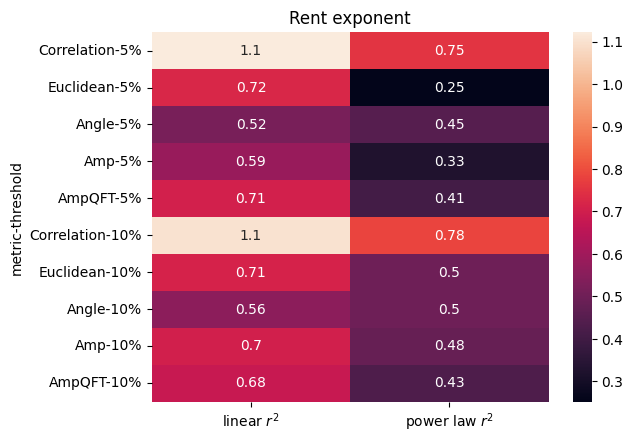

In [37]:
rent_exp_df_for_plot = rent_exps_df.set_index(['metric', 'threshold']).drop(columns=['low', 'high'])
rent_exp_df_for_plot['power law $r^2$'] = threshold_95_power_law_r2 + threshold_90_power_law_r2
sns.heatmap(rent_exp_df_for_plot, annot=True)
plt.title('Rent exponent')

# Small world propensity

In [38]:
rng = np.random.default_rng(42)

In [39]:
import small_world_propensity as swp

In [48]:
ms = [nx.adjacency_matrix(m).toarray() for m in threshold_95 + threshold_90]

In [49]:
its_a_small_world_after_all = swp.small_world_propensity(ms)

  0%|          | 0/10 [00:00<?, ?it/s]/home/user/work/quadrigems/notebooks/../small_world_propensity.py:59: RuntimeWarning: divide by zero encountered in divide
  path_matrix = csgraph.shortest_path(1/W, directed=False, unweighted=False)
/home/user/work/quadrigems/notebooks/../small_world_propensity.py:149: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.arctan(delta_L / delta_C)
100%|██████████| 10/10 [00:00<00:00, 263.32it/s]


In [50]:
its_a_small_world_after_all['metric'] = graph_labels*2 # string type
its_a_small_world_after_all['threshold'] = ['5%'] * 5 + ['10%'] * 5

In [52]:
its_a_small_world_after_all = its_a_small_world_after_all.set_index(['metric', 'threshold'])
its_a_small_world_after_all

In [57]:
its_a_small_world_after_all = its_a_small_world_after_all[['SWP']]

Text(0.5, 1.0, 'Small-world propensity')

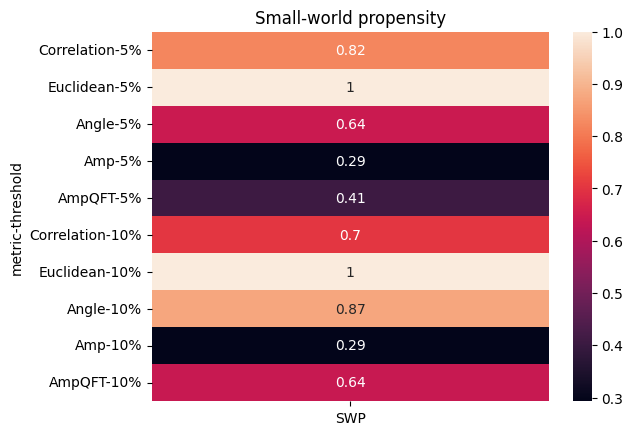

In [61]:
sns.heatmap(its_a_small_world_after_all, annot=True)
# plt.title("It's a small world after all")
plt.title("Small-world propensity")